In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
import yfinance as yf
from IPython.display import Markdown
from langchain_core.runnables import RunnableConfig
from langchain.schema import HumanMessage, AIMessage
import re
import datetime
from pykrx.stock import get_market_ticker_list, get_market_ticker_name
from langchain_community.agent_toolkits import FileManagementToolkit
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.document_loaders import PyMuPDFLoader, PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from markitdown import MarkItDown
import dotenv
import os

dotenv.load_dotenv()

True

In [688]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "tool_call Result"]

In [689]:
root_dir="./files"

In [690]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [691]:
tools = [TavilySearchResults(), PythonAstREPLTool(), FileManagementToolkit(selected_tools=["write_file"]).get_tools()[0]]
search_tool, code_tool, write_tool = tools

In [692]:
llm_with_tools = llm.bind_tools(tools)

In [694]:
history_checker = llm.with_structured_output(HistoryChecker)
intent_checker = llm.with_structured_output(IntentClassifier)

In [695]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [696]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                  "query":state["messages"][-1]})

    return result.yes_no

In [697]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    
    chain = prompt | llm

    answer = chain.invoke({"history":state["messages"][:-1],
                  "query":state["messages"][-1]})

    return {"messages":answer}

In [698]:
class IntentClassifier(BaseModel):
    """
    당신은 의도 분류 어시스턴트입니다.

    들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
    당신은 "code", "tool" 두개 중 하나로만 대답합니다.

    1. code : "문제가 데이터 분석 혹은 코드 실행과 관련된 문제일 경우 반환하는 값"
    ### code의 예시
    - 삼성전자의 거래량을 분석해주세요.
    - LS의 3월 21일 종가는 얼마인가요?
    - 100 + 100은 얼마인가요?
    - 로또번호 랜덤생성기 만들어주세요.
    - ```python import matplotlib.pyplot as plt import numpy as np
         df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
         df['성인여부'] = df['나이'] >= 20

         plt.bar(df['이름'], df['나이'], color='skyblue')
         plt.title('이름별 나이')
         plt.xlabel('이름')
         plt.ylabel('나이')
         plt.show()
      ```

    2. tool : "문제가 웹 서칭, 파일 관리, 일반 질의에 해당할 경우 반환하는 값"
    ### tool의 예시
    - 한국의 날씨는 어떤가요?
    - 조사한 내용의 레포트 작성해주세요.

    """

    binary : Literal["code", "tool"] = Field(..., description="""You are the intent classification assistant. 
                                             Determine what intention the question is.
                                             You only answer either "code" or "tool".
                                             """)

In [708]:
def intent_check(state:State):

    prompt = PromptTemplate.from_template("""

                당신은 의도 분류 어시스턴트입니다.

                들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
                당신은 "code", "tool" 두개 중 하나로만 대답합니다.
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | intent_checker

    result = chain.invoke({"query":state["messages"][-1]})

    return result.binary

In [709]:
def intent_node(state:State):
    return state

In [710]:
def select(
    state: State,
):
    try:
        message = state["messages"][-1]
    except:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"이전 대화 기록이 존재하지 않습니다.")
    
    result = llm_with_tools.invoke(message.content)

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = getattr(result, "tool_calls")[0]
        return {"tool_call": tool_calls}
    else:
        return {"tool_call":None}

    

In [711]:
# 주식 DB를 만드는 함수 {"삼성전자":"005930, ... }

def create_stock_db():
    stock_dict = {}
    today = datetime.datetime.today()
    
    stock_list = get_market_ticker_list(today, market="KOSPI")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})
    
    stock_list = get_market_ticker_list(today, market="KOSDAQ")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})

    return stock_dict

stock_db = create_stock_db()

In [712]:
def stock_search(state:State):

    """
    주식 검색 도구입니다.
    결과값으로 데이터프레임이 반환됩니다.
    입력 쿼리에서 주식이름을 추출한 후 모든 주식 데이터를 가져옵니다.
    """


    prompt = PromptTemplate.from_template("""
        당신은 주식 이름 추출기입니다.
        주어진 문장에서 주식이름만 추출하세요.

        ### 예시 1
        query : 삼성전자의 최근 1년에 대해서 분석해주세요.

        answer : 삼성전자

        ### 예시 2
        query : AJ홀딩스우의 최근 실적은 얼마인가요?

        answer : AJ홀딩스우

        ### 입력
        query : {query}

        answer : 

        """
        )
    
    chain = prompt | llm | StrOutputParser()

    stock_name = chain.invoke({"query":state["messages"][-1]})

    result = llm_with_tools.invoke(state["messages"][-1].content)

    try:
        stock_code = stock_db[stock_name.strip().upper()]   
    except:
        if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
            tool_calls = getattr(result, "tool_calls")[0]
            return {"tool_call": tool_calls}
        else:
            return {"tool_call":None}
        

    
    # 예: 삼성전자 (한국거래소는 뒤에 '.KS'를 붙임)
    ticker = yf.Ticker(stock_code+".KS")

    df = ticker.history(period="max") # 기간: '1d', '5d', '1mo', '1y', 'max' 등

    return {"df":df.reset_index().to_dict()}

In [ ]:
# tavily_search_results_json, python_repl_ast, read_file, write_file, list_directory

def tools(state:State):
    try:
        name = state["tool_call"]["name"]
    except:
        name = "llm"

    if name == "tavily_search_results_json":

        result = search_tool.invoke(state["tool_call"]["args"]["query"])
        prompt = ChatPromptTemplate.from_messages([
            ("system", """
                        당신은 아래 내용을 이용하여 답변합니다.
                        생각을 담지 말고 사실만을 전달하세요.
                        내용 : {result}

                        """),
            ("human", "{query}")
        ])

        chain = prompt | llm

        answer = chain.invoke({"result":result,
                               "query":state["messages"][-1]})
        
        return {"messages": answer}
    
    elif name == "python_repl_ast":

        if len(code_tool.locals) > 0:
            pass
        else:
            try:
                code_tool.locals = pd.DataFrame(state["df"])
            except:
                pass
            

        code = state["tool_call"]["args"]["query"]
        code_tool.invoke(code)

        prompt = ChatPromptTemplate.from_messages([
            ("system", """
                        아래의 코드를 참고하여 질의에 대해 답변합니다.
                        절대 코드에 대해 설명하지마세요.
                        독자는 프로그래머가 아닙니다.
                        항상 출력되는 값을 기준으로 설명합니다.
                        데이터 분석과 관련된 코드가 입력된다면 항상상 인사이트를 포함하세요.
                        단순한 코드라면 간단하게 대답합니다.

                        코드 : {code}

                        """),
            ("human", "{query}")
        ])

        chain = prompt | llm

        answer = chain.invoke({"code":code,
                               "query":state["messages"][-1]})
        
        return {"messages": answer}    

    elif name =="write_file":
        
        result = state["tool_calls"]["args"]
        
        prompt = PromptTemplate.from_template("""
                    당신은 입력된 정보를 레포트로 만들어내는 역할을 담당하고 있습니다.
                    
                    루트디렉토리의 위치는 "./files/" 입니다. 디렉토리 내부에 파일을 만들어주세요.
                    만들어지는 파일 형태는 .pdf파일이어야합니다.
                                              
                    input : {input}
                    
                    """)

        return write_tool.invoke(result)
    else:

        prompt = PromptTemplate.from_template("""
                질문에 대해 한글로 대답해주세요.

                질문 : {query}
                """
                )
        
        chain = prompt | llm

        return {"messages":chain.invoke({"query":state["messages"][-1]})}

In [724]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [744]:
graph = StateGraph(State)

In [745]:
graph.add_node("intent_node", intent_node)
graph.add_node("stock_search", stock_search)
graph.add_node("memory_chat", memory_chat)
graph.add_node("select", select)
graph.add_node("tools", tools)
graph.add_node("pretty_print", pretty_print)

graph.add_conditional_edges(START,
                            history_check,
                            {"yes":"memory_chat",
                             "no":"intent_node"})
graph.add_conditional_edges("intent_node",
                            intent_check,
                            {"code":"stock_search",
                             "tool":"select"})
graph.add_edge("stock_search", "tools")
graph.add_edge("select", "tools")
graph.add_edge("tools", "pretty_print")
graph.add_edge("memory_chat", "pretty_print")
graph.add_edge("pretty_print", END);

In [753]:
memory = MemorySaver()

app = graph.compile(checkpointer=memory)

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1054"})

In [752]:
app = graph.compile()

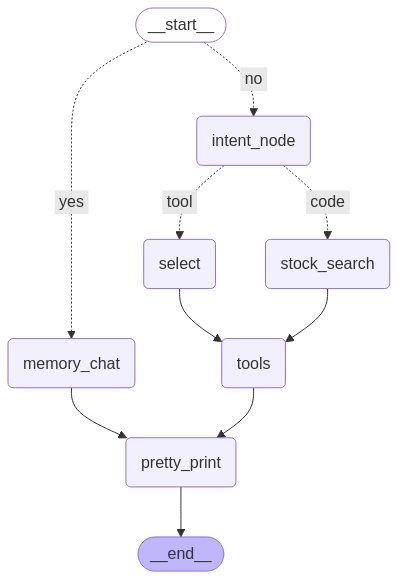

In [633]:
app

In [227]:
result = app.invoke({"messages":("user", "피엔티에 대해 알려주세요.")}, config=config)

content='피엔티에 대해 알려주세요.' additional_kwargs={} response_metadata={} id='33fc80c0-151b-4d7f-ab19-5b120da85c87'
content='피엔티는 롤투롤 컨버팅 기계를 주력으로 성장한 회사입니다. 주요 기술로는 웹가이딩, 장력제어, 오토터렛, 오토스플라이싱, 코팅, 칼렌더링, 슬리팅 등이 있습니다. 이 회사는 디스플레이 소재용 필름, 전자전기 및 2차 전지의 분리막, 음극, 양극 소재 등을 생산하는 장비를 개발하고 있습니다. 또한, IT용 소재와 2차 전지의 음극 및 분리막 소재, Copper 등의 코팅 및 슬리터 장비의 제작 판매를 주요 사업으로 하고 있습니다. \n\n자세한 정보는 다음 링크에서 확인할 수 있습니다:\n- [피엔티 공식 웹사이트](https://www.epnt.co.kr/)\n- [사람인 기업정보](https://www.saramin.co.kr/zf_user/company-info/view/csn/Zm9qNG9WcGt6dlp0RWxvelMrSnVHUT09/company_nm/(%EC%A3%BC)%ED%94%BC%EC%97%94%ED%8B%B0)\n- [삼성전자 기업정보](https://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?gicode=A137400)\n- [나무위키](https://namu.wiki/w/%ED%94%BC%EC%97%94%ED%8B%B0)' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 316, 'prompt_tokens': 714, 'total_tokens': 1030, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens'

In [ ]:
result = app.invoke({"messages":("user", "30+30은 뭐야?")}, config=config)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

In [750]:
result = app.invoke({"messages":("user", "내가 아까 뭐라고 질문했지?")}, config=config)



===== Result =====


죄송하지만, 이전의 대화 내용을 기억할 수 없어서 어떤 질문을 하셨는지 알 수 없습니다. 다시 질문해 주시면 최선을 다해 답변해 드리겠습니다.


In [743]:
result

{'messages': [HumanMessage(content='30+30은 뭐야?', additional_kwargs={}, response_metadata={}, id='c8e19729-838f-453f-9241-9a56395c1958'),
  AIMessage(content='30 + 30은 60입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 108, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae4e792b-d37d-4e47-be4a-29637762ccc5-0', usage_metadata={'input_tokens': 108, 'output_tokens': 10, 'total_tokens': 118, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='내가 아까 뭐라고 질문했지?', additional_kwargs={}, response_metadata={}, id='6d7933ca-cbdc-4871-9404-b22

In [721]:
result = app.invoke({"messages":("user", """import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
df['성인여부'] = df['나이'] >= 20

plt.bar(df['이름'], df['나이'], color='skyblue')
plt.title('이름별 나이')
plt.xlabel('이름')
plt.ylabel('나이')
plt.show()
""")})

content="2023년 추천 주식에 대한 정보는 다음과 같습니다:\n\n1. **방위산업체**: 레이시온 테크놀로지스, 록히드 마틴, 노스롭 그루먼은 주가 상승이 예상됩니다. [자세히 보기](https://kr.investing.com/analysis/article-200442223)\n\n2. **제약회사**: 일라이 릴리, 머크, 브리스톨 마이어스 스퀴브는 시장보다 높은 수익률이 예상됩니다. [자세히 보기](https://www.hankyung.com/article/202212299176O)\n\n3. **2024년 추가 상승 예상 주식**: 우버, 블랙스톤, 인텔, 크라우드스트라이크, 익스피디아. [자세히 보기](https://kr.investing.com/analysis/article-200446203)\n\n이 외에도 2023년 주식시장에서 '의료AI', 2차전지, 로봇, 반도체 등의 테마가 주목받고 있습니다. [자세히 보기](https://stockplus.com/m/investing_strategies/articles/6449?scope=all)" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 259, 'prompt_tokens': 691, 'total_tokens': 950, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'lo

In [730]:
result = app.invoke({"messages":("user", """
어떤 주식을 사는게 좋을까?
""")})

content='2023년 추천 주식으로는 다음과 같은 종목들이 있습니다:\n\n1. 레이시온 테크놀로지스\n2. 록히드 마틴\n3. 노스롭 그루먼\n4. 일라이 릴리\n5. 머크\n6. 브리스톨 마이어스 스퀴브\n\n이 외에도 2023년에 이어 2024년에도 추가 상승할 것으로 예상되는 주식으로는 우버, 블랙스톤, 인텔, 크라우드스트라이크, 익스피디아가 있습니다. \n\n자세한 내용은 각 링크를 참조하시기 바랍니다:\n- [2023년 시장 전망: 새해를 위한 추천 주식 15종목 | Investing.com](https://kr.investing.com/analysis/article-200442223)\n- [2023년 시장 전망: 새해를 위한 추천 주식 15종목 | 한경닷컴](https://www.hankyung.com/article/202212299176O)\n- [2023년에 이어 2024년에도 추가 상승할 만한 주식 5종목 - 인베스팅닷컴](https://kr.investing.com/analysis/article-200446203)' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 260, 'prompt_tokens': 691, 'total_tokens': 951, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': Non

In [731]:
result = app.invoke({"messages":("user", "이유에 대해서도 알려줘")})



===== Result =====


물론입니다! 질문에 대한 이유를 설명해 드리겠습니다. 어떤 주제에 대한 이유를 알고 싶으신가요? 구체적인 내용을 말씀해 주시면 더 자세히 답변해 드릴 수 있습니다.


In [732]:
result

{'messages': [HumanMessage(content='이유에 대해서도 알려줘', additional_kwargs={}, response_metadata={}, id='571e5ccb-1317-47cc-bf9a-9b9bb5ead4f0'),
  AIMessage(content='물론입니다! 질문에 대한 이유를 설명해 드리겠습니다. 어떤 주제에 대한 이유를 알고 싶으신가요? 구체적인 내용을 말씀해 주시면 더 자세히 답변해 드릴 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 66, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-f9ac2e9b-1589-4635-a335-5085752226c3-0', usage_metadata={'input_tokens': 66, 'output_tokens': 49, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'tool_call': None}

In [203]:
c.invoke({"history":history})

AIMessage(content='피엔티는 롤투롤 컨버팅 기계의 세계적인 전문가로, 다양한 롤투롤 컨버팅 기계를 주력으로 성장한 회사입니다. 주요 기술로는 웹 가이딩, 장력 제어, 오토 터렛, 오토 스플라이싱, 코팅, 칼렌더링, 슬리팅 등이 있습니다.\n\n회사는 디스플레이 소재용 필름, 전자전기 및 소형 및 ESS용 중대형 2차 전지의 분리막, 음극, 양극 소재, 그리고 회로 소재 및 2차 전지용 극박 등을 생산하는 장비를 개발하고 있습니다.\n\n피엔티의 주요 사업은 IT용 소재, 2차 전지의 음극 및 분리막 소재, Copper 등의 코팅 및 슬리터 장비의 제작 및 판매입니다.\n\n자세한 정보는 다음 링크에서 확인할 수 있습니다:\n- [피엔티 공식 웹사이트](https://www.epnt.co.kr/)\n- [사람인 기업정보](https://www.saramin.co.kr/zf_user/company-info/view/csn/Zm9qNG9WcGt6dlp0RWxvelMrSnVHUT09/company_nm/(%EC%A3%BC)%ED%94%BC%EC%97%94%ED%8B%B0)\n- [삼성전자 기업정보](https://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?gicode=A137400)\n- [나무위키](https://namu.wiki/w/%ED%94%BC%EC%97%94%ED%8B%B0)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 353, 'prompt_tokens': 654, 'total_tokens': 1007, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':